In [1]:
import os
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from itertools import cycle
import seaborn as sns
import statsmodels.api as sm 
from scipy.interpolate import interp1d
from prophet import Prophet

pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
%%time
oj = os.path.join
INPUT_DIR = '../input/m5-forecasting-accuracy/'
train = pd.read_csv(oj(INPUT_DIR, 'trainset.csv'))
price = pd.read_csv(oj(INPUT_DIR, 'sell_prices.csv'))
calendar = pd.read_csv(oj(INPUT_DIR, 'calendar.csv'))

sample_submit = pd.read_csv(oj(INPUT_DIR, 'submit.csv'))

CPU times: user 8.82 s, sys: 1.94 s, total: 10.8 s
Wall time: 16.3 s


In [3]:
print(calendar['event_name_1'].unique())

[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']


In [4]:
print(calendar['event_type_1'].unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']


In [5]:
print(calendar['event_name_2'].unique())

[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [6]:
print(calendar['event_type_2'].unique())

[nan 'Cultural' 'Religious']


In [7]:
print(price.head())
print(price.shape)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
(6841121, 4)


In [9]:
print(train.shape)

(30490, 1933)


In [11]:
holidays = calendar[['date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
holidays = holidays.rename(columns={'date': 'ds'})
holidays = holidays.dropna(subset = ['event_name_1'])
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays = holidays[['ds', 'lower_window', 'upper_window']]
holidays = holidays.reset_index(drop=True)
print(holidays.head())



            ds   event_name_1 event_type_1 event_name_2 event_type_2  \
8   2011-02-06      SuperBowl     Sporting          NaN          NaN   
16  2011-02-14  ValentinesDay     Cultural          NaN          NaN   
23  2011-02-21  PresidentsDay     National          NaN          NaN   
39  2011-03-09      LentStart    Religious          NaN          NaN   
46  2011-03-16      LentWeek2    Religious          NaN          NaN   

    lower_window  upper_window  
8              0             1  
16             0             1  
23             0             1  
39             0             1  
46             0             1  


C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  1        8.38
1923  2016-05-05  d_1924     11614  1        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  2        8.38
1926  2016-05-08  d_1927     11615  1        8.38

[1927 rows x 5 columns]
-------------------


04:10:37 - cmdstanpy - INFO - Chain [1] start processing
04:10:37 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.871088   -0.043710    1.498135     0.871088     0.871088   
1928 2016-05-10  0.871672    0.011317    1.567387     0.871672     0.871672   
1929 2016-05-11  0.872256   -0.095326    1.473815     0.872256     0.872256   
1930 2016-05-12  0.872840   -0.152501    1.433731     0.872840     0.872840   
1931 2016-05-13  0.873423   -0.211347    1.497969     0.873423     0.873423   
1932 2016-05-14  0.874007    0.009498    1.684576     0.874007     0.874007   
1933 2016-05-15  0.874591   -0.096687    1.520953     0.874591     0.874591   
1934 2016-05-16  0.875175   -0.196891    1.385855     0.875175     0.875175   
1935 2016-05-17  0.875759   -0.052348    1.553495     0.875759     0.875

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


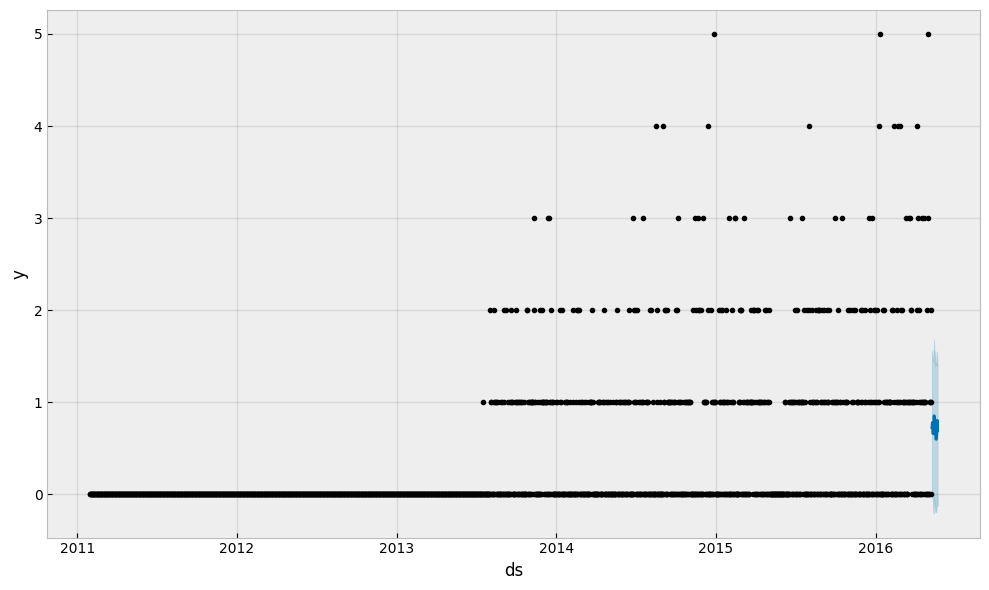

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  1        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:38 - cmdstanpy - INFO - Chain [1] start processing
04:10:39 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.349506   -0.382142    1.017755     0.349506     0.349506   
1928 2016-05-10  0.349591   -0.380036    1.009441     0.349591     0.349591   
1929 2016-05-11  0.349676   -0.385053    1.052665     0.349676     0.349676   
1930 2016-05-12  0.349760   -0.280248    1.100720     0.349760     0.349760   
1931 2016-05-13  0.349845   -0.285342    1.107594     0.349845     0.349845   
1932 2016-05-14  0.349930   -0.206563    1.159856     0.349930     0.349930   
1933 2016-05-15  0.350014   -0.241610    1.048534     0.350014     0.350014   
1934 2016-05-16  0.350099   -0.380026    1.026700     0.350099     0.350099   
1935 2016-05-17  0.350184   -0.363632    1.056912     0.350184     0.350

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


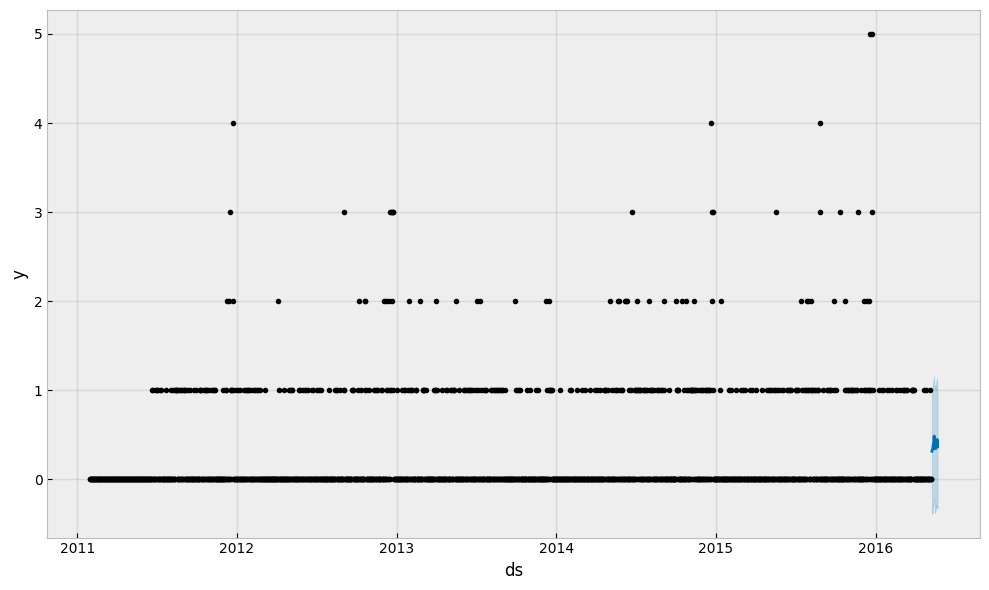

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  2        8.38
1925  2016-05-07  d_1926     11615  1        8.38
1926  2016-05-08  d_1927     11615  3        8.38

[1927 rows x 5 columns]
-------------------


04:10:40 - cmdstanpy - INFO - Chain [1] start processing
04:10:40 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.707064    0.121980    1.238516     0.707064     0.707064   
1928 2016-05-10  0.708025    0.103365    1.280110     0.708025     0.708025   
1929 2016-05-11  0.708985    0.140074    1.236208     0.708985     0.708985   
1930 2016-05-12  0.709946    0.172067    1.262225     0.709946     0.709946   
1931 2016-05-13  0.710907    0.196072    1.321231     0.710907     0.710907   
1932 2016-05-14  0.711867    0.288297    1.399172     0.711867     0.711867   
1933 2016-05-15  0.712828    0.163310    1.307294     0.712828     0.712828   
1934 2016-05-16  0.713788    0.171792    1.252411     0.713788     0.713788   
1935 2016-05-17  0.714749    0.166501    1.262515     0.714749     0.714

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


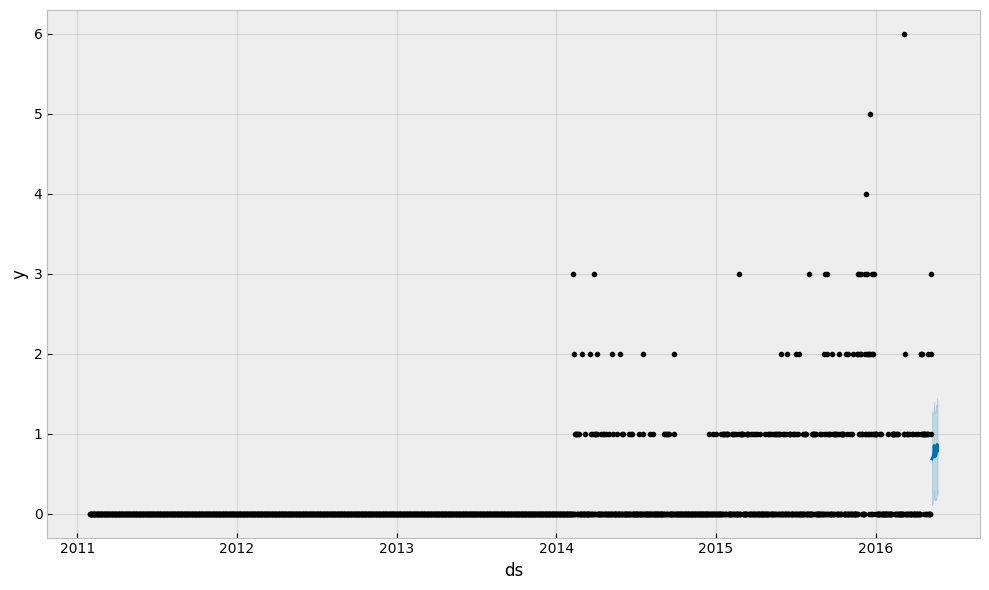

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  2        8.38
1925  2016-05-07  d_1926     11615  2        8.38
1926  2016-05-08  d_1927     11615  4        8.38

[1927 rows x 5 columns]
-------------------


04:10:42 - cmdstanpy - INFO - Chain [1] start processing
04:10:43 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  1.851140   -0.647404    3.832716     1.851140     1.851140   
1928 2016-05-10  1.850159   -0.997345    3.581278     1.850159     1.850159   
1929 2016-05-11  1.849178   -0.929577    3.484581     1.849178     1.849178   
1930 2016-05-12  1.848197   -0.486073    3.932638     1.848197     1.848197   
1931 2016-05-13  1.847217   -0.859692    4.012052     1.847217     1.847217   
1932 2016-05-14  1.846236    0.673152    5.170866     1.846236     1.846236   
1933 2016-05-15  1.845255    1.189458    5.662732     1.845255     1.845255   
1934 2016-05-16  1.844274   -0.584784    3.999011     1.844274     1.844274   
1935 2016-05-17  1.843293   -0.736440    3.537139     1.843293     1.843

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


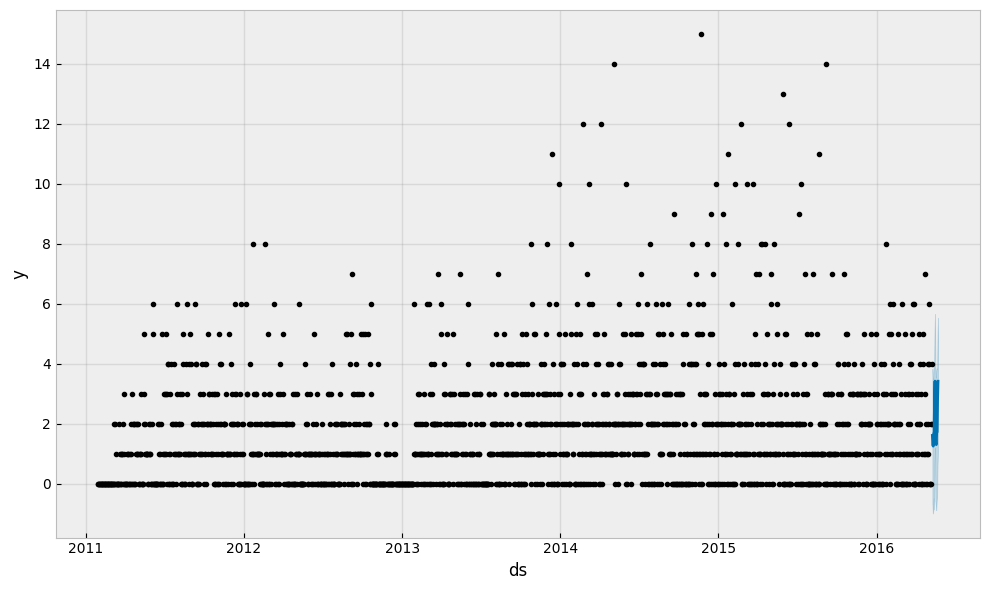

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  1        8.38
1923  2016-05-05  d_1924     11614  1        8.38
1924  2016-05-06  d_1925     11614  3        8.38
1925  2016-05-07  d_1926     11615  2        8.38
1926  2016-05-08  d_1927     11615  3        8.38

[1927 rows x 5 columns]
-------------------


04:10:45 - cmdstanpy - INFO - Chain [1] start processing
04:10:45 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  1.265955   -0.849074    2.328170     1.265955     1.265955   
1928 2016-05-10  1.266327   -0.871528    2.267296     1.266327     1.266327   
1929 2016-05-11  1.266698   -0.646585    2.458075     1.266698     1.266698   
1930 2016-05-12  1.267069   -0.792201    2.595617     1.267069     1.267069   
1931 2016-05-13  1.267441   -0.619360    2.688588     1.267441     1.267441   
1932 2016-05-14  1.267812   -0.067592    3.097293     1.267812     1.267812   
1933 2016-05-15  1.268184   -0.106510    3.058212     1.268184     1.268184   
1934 2016-05-16  1.268555   -0.703946    2.653737     1.268555     1.268555   
1935 2016-05-17  1.268927   -0.626123    2.599945     1.268927     1.268

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


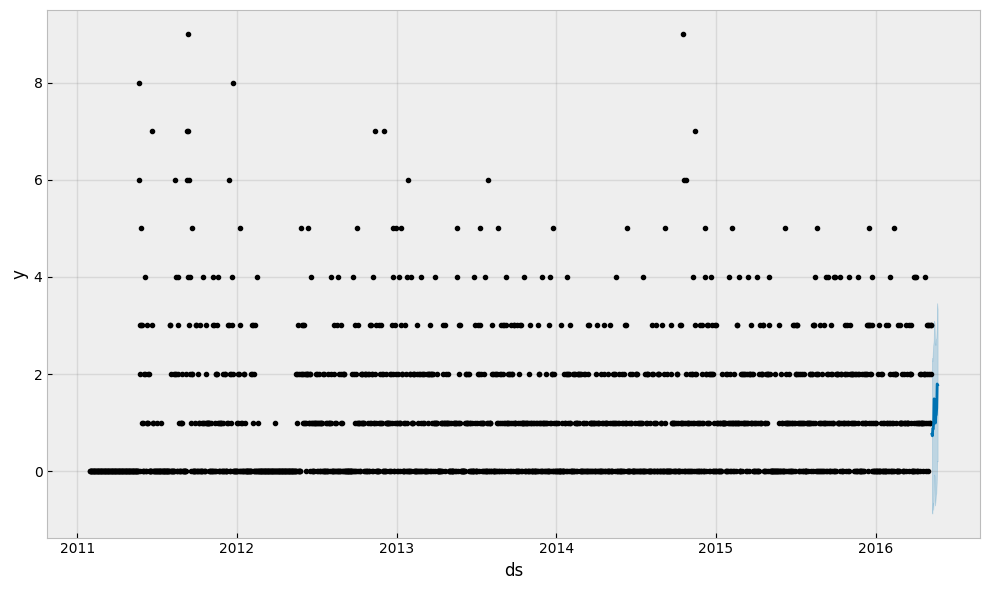

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  2        8.38
1925  2016-05-07  d_1926     11615  1        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:46 - cmdstanpy - INFO - Chain [1] start processing
04:10:47 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.530837   -1.051928    2.717367     0.530837     0.530837   
1928 2016-05-10  0.530075   -1.149190    2.541892     0.530075     0.530075   
1929 2016-05-11  0.529312   -1.377129    2.445895     0.529312     0.529312   
1930 2016-05-12  0.528549   -1.334375    2.616974     0.528549     0.528549   
1931 2016-05-13  0.527787   -1.336942    2.376739     0.527787     0.527787   
1932 2016-05-14  0.527024   -1.088851    2.820499     0.527024     0.527024   
1933 2016-05-15  0.526261   -1.126679    2.664318     0.526261     0.526261   
1934 2016-05-16  0.525499   -1.099083    2.711403     0.525499     0.525499   
1935 2016-05-17  0.524736   -1.237147    2.443336     0.524736     0.524

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


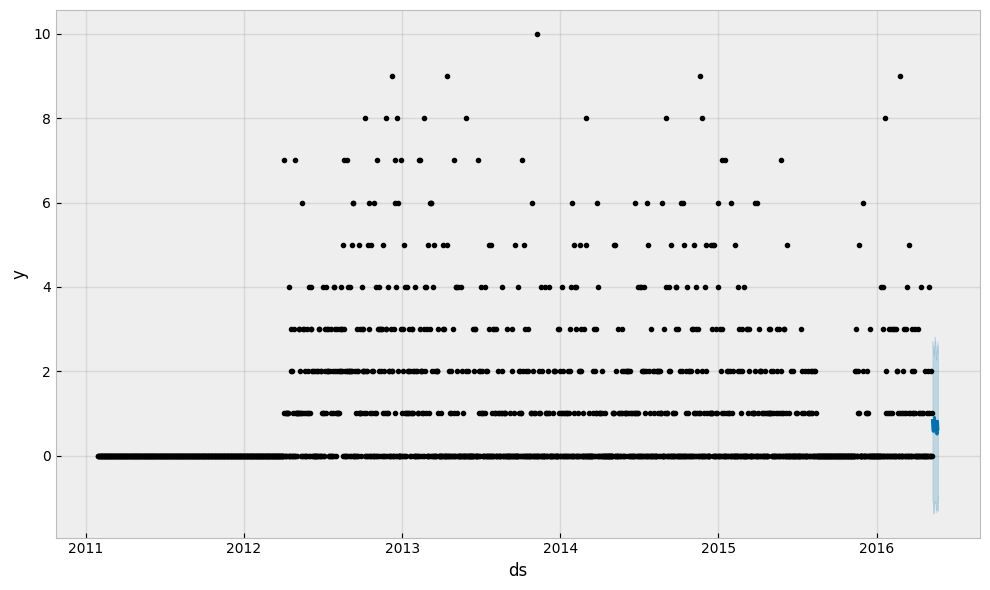

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  1        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:48 - cmdstanpy - INFO - Chain [1] start processing
04:10:49 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.287476   -0.269942    0.953962     0.287476     0.287476   
1928 2016-05-10  0.287415   -0.339532    0.925223     0.287415     0.287415   
1929 2016-05-11  0.287354   -0.356974    0.857583     0.287354     0.287354   
1930 2016-05-12  0.287293   -0.306875    0.910021     0.287293     0.287293   
1931 2016-05-13  0.287231   -0.267537    0.938286     0.287231     0.287231   
1932 2016-05-14  0.287170   -0.209525    1.019677     0.287170     0.287170   
1933 2016-05-15  0.287109   -0.287752    0.948607     0.287109     0.287109   
1934 2016-05-16  0.287048   -0.356991    0.924753     0.287048     0.287048   
1935 2016-05-17  0.286986   -0.271393    0.909660     0.286986     0.286

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


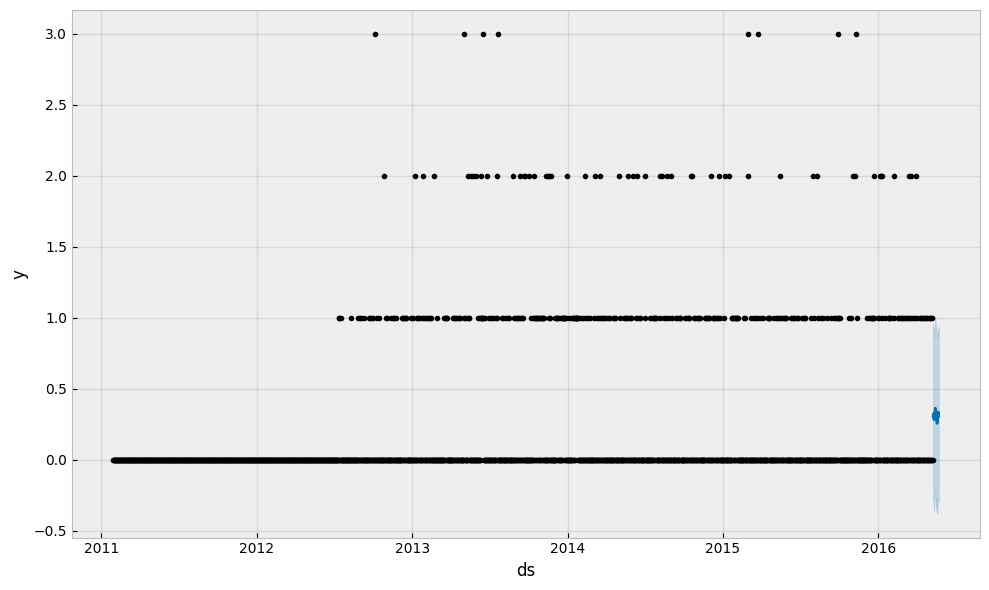

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk   y  sell_price
0     2011-01-29     d_1     11101  12         NaN
1     2011-01-30     d_2     11101  15         NaN
2     2011-01-31     d_3     11101   0         NaN
3     2011-02-01     d_4     11101   0         NaN
4     2011-02-02     d_5     11101   0         NaN
...          ...     ...       ...  ..         ...
1922  2016-05-04  d_1923     11614   8        8.38
1923  2016-05-05  d_1924     11614   5        8.38
1924  2016-05-06  d_1925     11614   8        8.38
1925  2016-05-07  d_1926     11615   5        8.38
1926  2016-05-08  d_1927     11615   0        8.38

[1927 rows x 5 columns]
-------------------


04:10:50 - cmdstanpy - INFO - Chain [1] start processing
04:10:50 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  10.471916   -2.086589   20.062077    10.471916    10.471916   
1928 2016-05-10  10.475044   -2.837017   19.173625    10.475044    10.475044   
1929 2016-05-11  10.478171   -1.621986   20.894591    10.478171    10.478171   
1930 2016-05-12  10.481299   -3.048110   19.706913    10.481299    10.481299   
1931 2016-05-13  10.484426   -1.830206   19.715353    10.484426    10.484426   
1932 2016-05-14  10.487554   -0.245663   22.656984    10.487554    10.487554   
1933 2016-05-15  10.490681   -2.564608   19.184395    10.490681    10.490681   
1934 2016-05-16  10.493809   -2.517485   20.524066    10.493809    10.493809   
1935 2016-05-17  10.496936   -2.855257   19.832575    10.496936

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


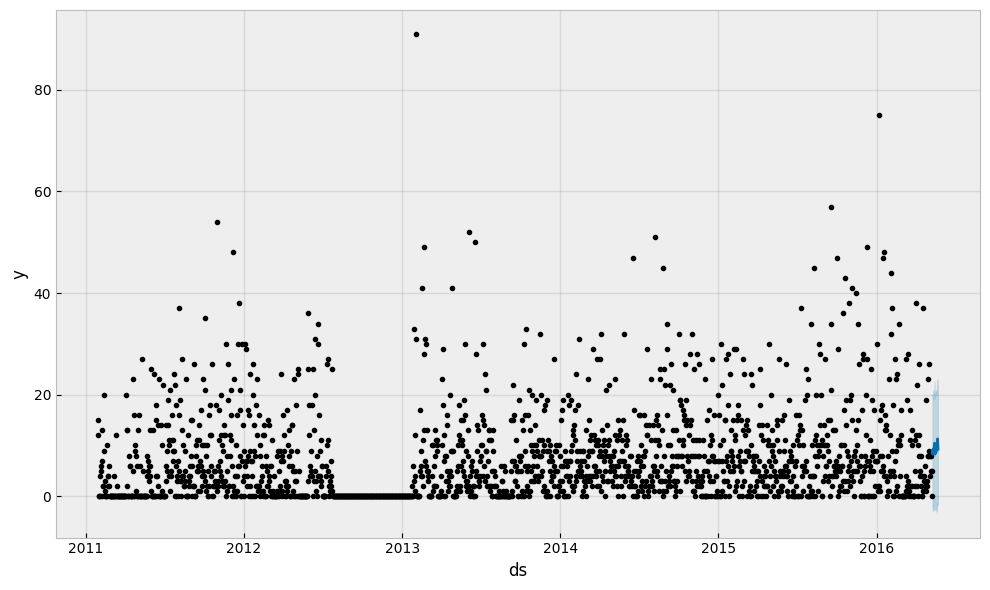

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  2         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  7         NaN
3     2011-02-01     d_4     11101  3         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  8        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:52 - cmdstanpy - INFO - Chain [1] start processing
04:10:52 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.179781   -2.475807    2.638679     0.179781     0.179781   
1928 2016-05-10  0.178610   -2.146261    2.712521     0.178610     0.178610   
1929 2016-05-11  0.177439   -2.358671    2.745081     0.177439     0.177439   
1930 2016-05-12  0.176268   -2.351757    2.515935     0.176268     0.176268   
1931 2016-05-13  0.175096   -2.507047    2.512789     0.175096     0.175096   
1932 2016-05-14  0.173925   -1.824420    2.960254     0.173925     0.173925   
1933 2016-05-15  0.172754   -2.059690    2.767919     0.172754     0.172754   
1934 2016-05-16  0.171583   -2.207112    2.652359     0.171583     0.171583   
1935 2016-05-17  0.170412   -2.227041    2.833473     0.170412     0.170

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


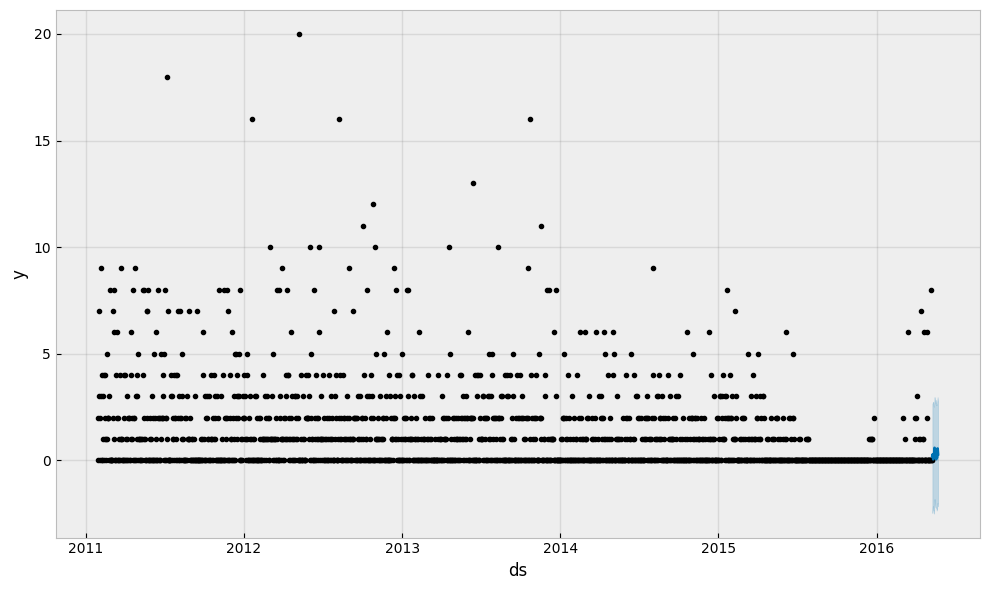

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  1         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  2        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  2        8.38

[1927 rows x 5 columns]
-------------------


04:10:54 - cmdstanpy - INFO - Chain [1] start processing
04:10:55 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.540100   -0.771784    1.458800     0.540100     0.540100   
1928 2016-05-10  0.539798   -0.805254    1.457529     0.539798     0.539798   
1929 2016-05-11  0.539495   -0.714650    1.483173     0.539495     0.539495   
1930 2016-05-12  0.539192   -0.816819    1.354992     0.539192     0.539192   
1931 2016-05-13  0.538890   -0.696450    1.504509     0.538890     0.538890   
1932 2016-05-14  0.538587   -0.699331    1.661502     0.538587     0.538587   
1933 2016-05-15  0.538284   -0.239188    1.991897     0.538284     0.538284   
1934 2016-05-16  0.537982   -0.790588    1.453870     0.537982     0.537982   
1935 2016-05-17  0.537679   -0.792386    1.542078     0.537679     0.537

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


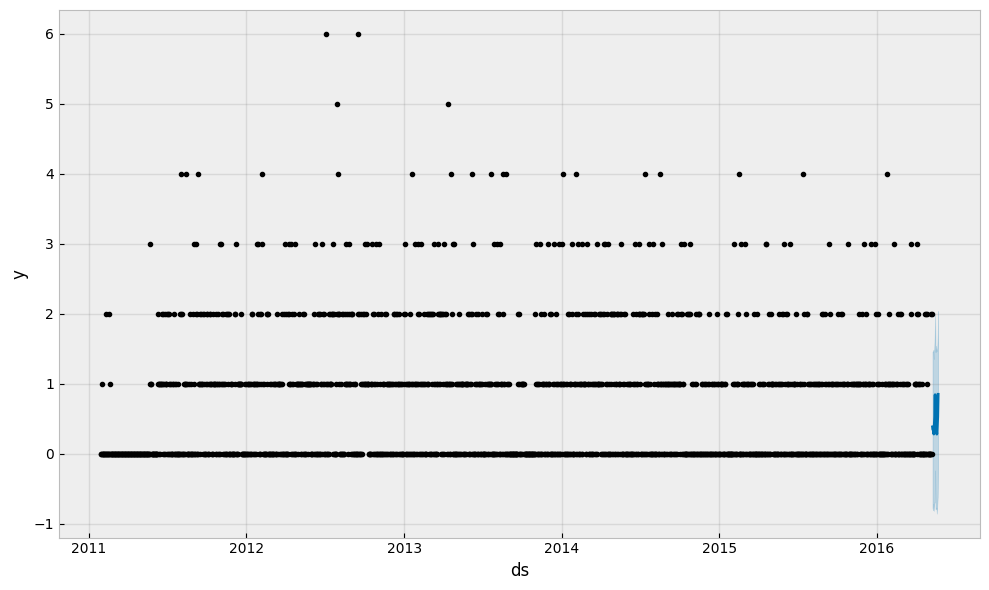

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  0        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:56 - cmdstanpy - INFO - Chain [1] start processing
04:10:57 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.106468   -0.260130    0.463282     0.106468     0.106468   
1928 2016-05-10  0.106563   -0.314758    0.434226     0.106563     0.106563   
1929 2016-05-11  0.106658   -0.247531    0.472964     0.106658     0.106658   
1930 2016-05-12  0.106753   -0.250046    0.449269     0.106753     0.106753   
1931 2016-05-13  0.106848   -0.246612    0.509515     0.106848     0.106848   
1932 2016-05-14  0.106943   -0.188292    0.516453     0.106943     0.106943   
1933 2016-05-15  0.107038   -0.165565    0.569794     0.107038     0.107038   
1934 2016-05-16  0.107133   -0.246911    0.469629     0.107133     0.107133   
1935 2016-05-17  0.107228   -0.236295    0.501813     0.107228     0.107

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


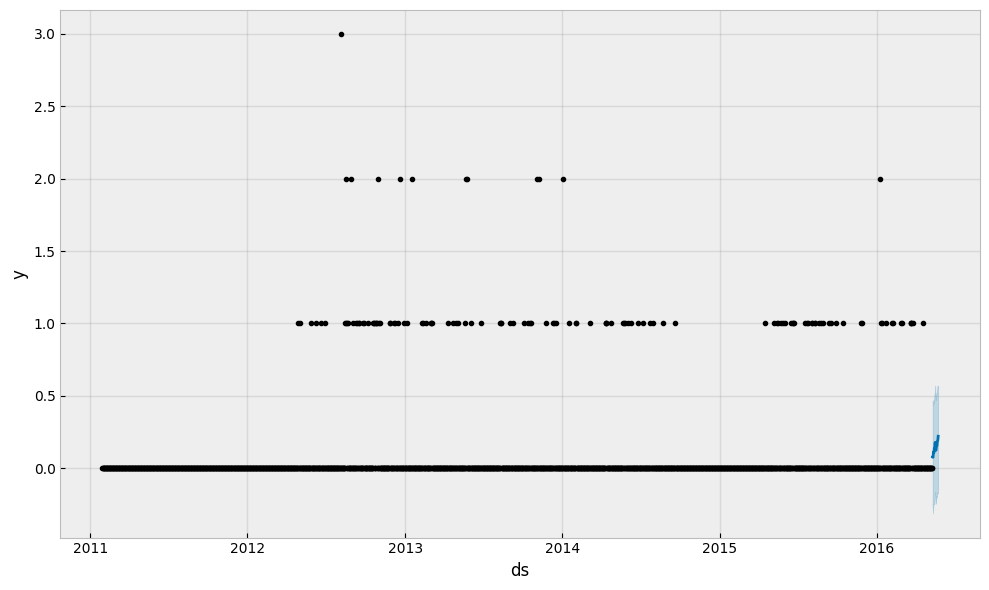

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  2         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  1        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:10:58 - cmdstanpy - INFO - Chain [1] start processing
04:10:58 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.160433   -0.597406    1.062166     0.160433     0.160433   
1928 2016-05-10  0.160158   -0.607914    0.973525     0.160158     0.160158   
1929 2016-05-11  0.159883   -0.698742    0.979287     0.159883     0.159883   
1930 2016-05-12  0.159608   -0.587647    1.016038     0.159608     0.159608   
1931 2016-05-13  0.159333   -0.536740    1.046148     0.159333     0.159333   
1932 2016-05-14  0.159058   -0.438841    1.154808     0.159058     0.159058   
1933 2016-05-15  0.158784   -0.405118    1.155636     0.158784     0.158784   
1934 2016-05-16  0.158509   -0.521138    1.078874     0.158509     0.158509   
1935 2016-05-17  0.158234   -0.648973    0.992910     0.158234     0.158

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


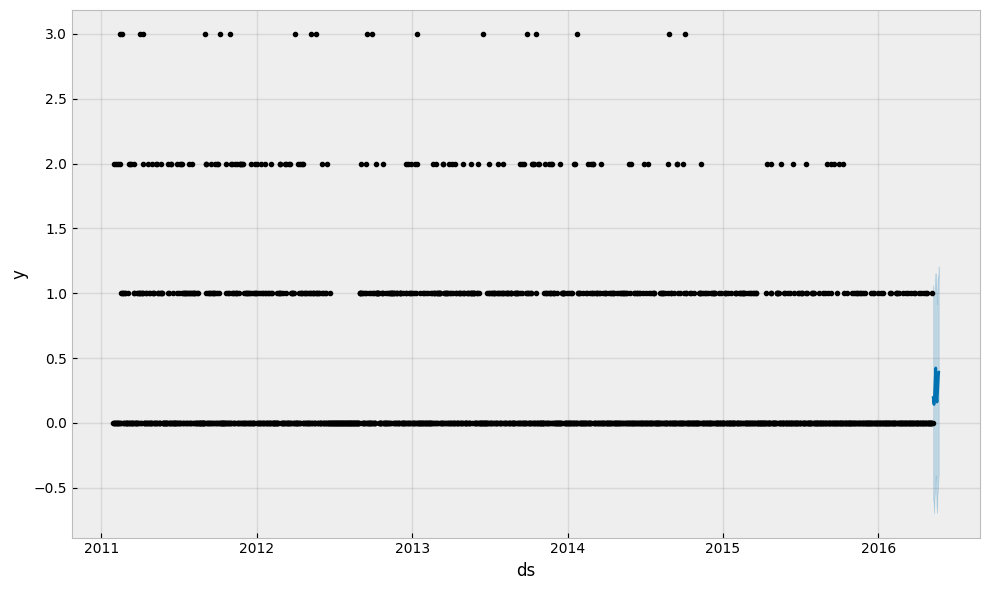

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  0        8.38
1923  2016-05-05  d_1924     11614  0        8.38
1924  2016-05-06  d_1925     11614  1        8.38
1925  2016-05-07  d_1926     11615  0        8.38
1926  2016-05-08  d_1927     11615  0        8.38

[1927 rows x 5 columns]
-------------------


04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  0.373500   -0.265458    1.062789     0.373500     0.373500   
1928 2016-05-10  0.373526   -0.293276    1.118825     0.373526     0.373526   
1929 2016-05-11  0.373551   -0.252345    1.127663     0.373551     0.373551   
1930 2016-05-12  0.373576   -0.301781    1.067130     0.373576     0.373576   
1931 2016-05-13  0.373602   -0.258498    1.141693     0.373602     0.373602   
1932 2016-05-14  0.373627   -0.201704    1.211127     0.373627     0.373627   
1933 2016-05-15  0.373653   -0.118287    1.222089     0.373653     0.373653   
1934 2016-05-16  0.373678   -0.315719    1.059083     0.373678     0.373678   
1935 2016-05-17  0.373704   -0.307372    1.099131     0.373704     0.373

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


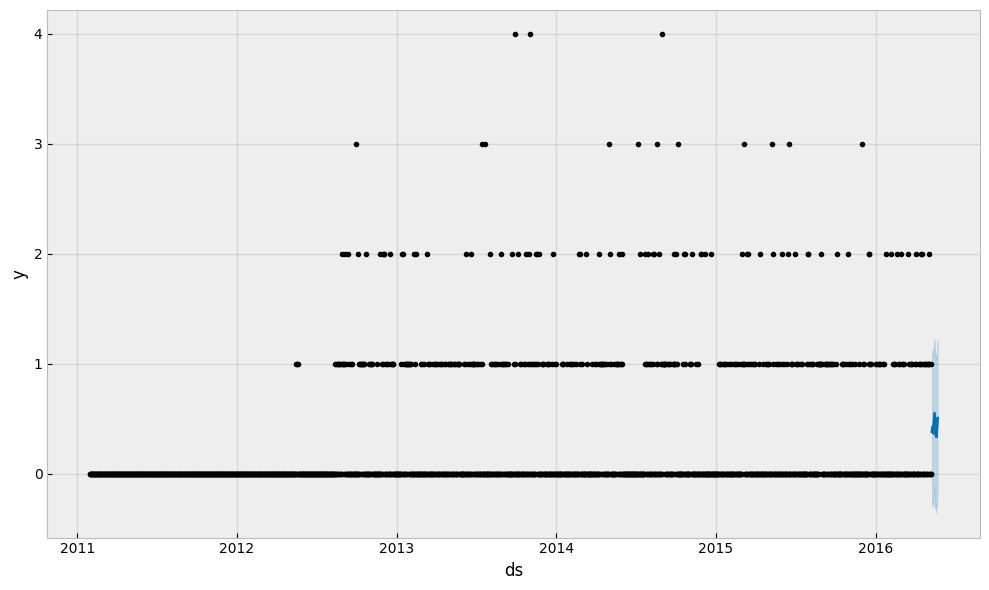

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


              ds       d  wm_yr_wk  y  sell_price
0     2011-01-29     d_1     11101  0         NaN
1     2011-01-30     d_2     11101  0         NaN
2     2011-01-31     d_3     11101  0         NaN
3     2011-02-01     d_4     11101  0         NaN
4     2011-02-02     d_5     11101  0         NaN
...          ...     ...       ... ..         ...
1922  2016-05-04  d_1923     11614  3        8.38
1923  2016-05-05  d_1924     11614  1        8.38
1924  2016-05-06  d_1925     11614  4        8.38
1925  2016-05-07  d_1926     11615  1        8.38
1926  2016-05-08  d_1927     11615  2        8.38

[1927 rows x 5 columns]
-------------------


04:11:02 - cmdstanpy - INFO - Chain [1] start processing
04:11:02 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    2011-01-29
1    2011-01-30
2    2011-01-31
3    2011-02-01
4    2011-02-02
...         ...
1936 2016-05-18
1937 2016-05-19
1938 2016-05-20
1939 2016-05-21
1940 2016-05-22

[1941 rows x 1 columns]
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1927 2016-05-09  1.896511   -0.035068    3.628512     1.896511     1.896511   
1928 2016-05-10  1.897062   -0.173332    3.435216     1.897062     1.897062   
1929 2016-05-11  1.897614   -0.140270    3.731769     1.897614     1.897614   
1930 2016-05-12  1.898165   -0.072371    3.779400     1.898165     1.898165   
1931 2016-05-13  1.898716    0.334215    4.047826     1.898716     1.898716   
1932 2016-05-14  1.899268    0.266153    3.971233     1.899268     1.899268   
1933 2016-05-15  1.899819    0.059033    3.813796     1.899819     1.899819   
1934 2016-05-16  1.900370   -0.182421    3.600105     1.900370     1.900370   
1935 2016-05-17  1.900921   -0.199208    3.568966     1.900921     1.900

c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\fuyuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


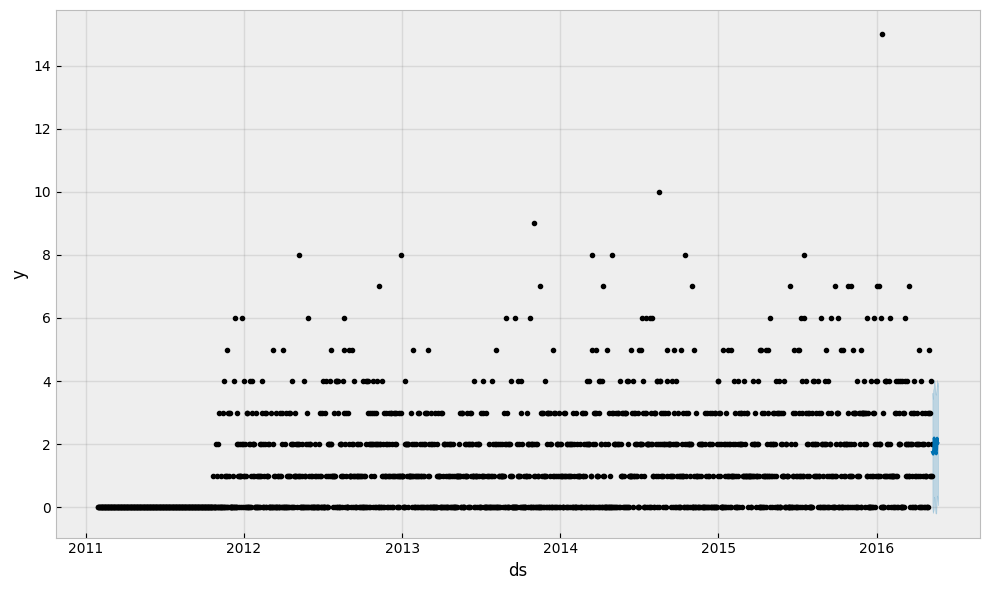

C:\Users\fuyuki\AppData\Local\Temp\ipykernel_53100\4000262814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values


KeyboardInterrupt: 

In [28]:
for i in range(train.shape[0]):
    df = pd.DataFrame(calendar[['date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']])
    df_train =  df.loc[0:1926]
    df_test = df.loc[1927:]
    #print(df_train)
    #print(df_test)
    df_train['y'] = train.loc[i,'d_1':].values
    df_train = pd.merge(df_train, price[(price['store_id'] == train.loc[i,'store_id']) & (price['item_id'] == train.loc[0,'item_id'])][['wm_yr_wk', 'sell_price']], how='left', on=['wm_yr_wk'])
    df_train = df_train.rename(columns={'date': 'ds'})
    #df_train = df_train.drop(["price"], axis=1)
    print(df_train)
    print("-------------------")
    
    model = Prophet()
    model.fit(df_train)
    future = model.make_future_dataframe(periods=14)
    print(future)
    forecast = model.predict(future)
    print(forecast.tail(14))
    model.plot(forecast.tail(14))
    plt.show()
    #df_train.to_csv('df_train' + str(i) + '.csv', index=False)